In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Transformations for CIFAR-10 (Resized to 224 for AlexNet/VGG compatibility)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

Using device: cuda


In [4]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss()(inputs, targets)
        pt = torch.exp(-ce_loss)
        return self.alpha * (1 - pt)**self.gamma * ce_loss

In [5]:
def get_model(model_name):
    if model_name == "LeNet-5":
        return nn.Sequential(
            nn.Conv2d(3, 6, 5), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Flatten(), nn.Linear(16 * 53 * 53, 120), nn.ReLU(),
            nn.Linear(120, 84), nn.ReLU(), nn.Linear(84, 10)
        )
    elif model_name == "AlexNet":
        model = models.alexnet(weights=None)
        model.classifier[6] = nn.Linear(4096, 10)
        return model
    elif model_name == "VGGNet":
        model = models.vgg16(weights=None)
        model.classifier[6] = nn.Linear(4096, 10)
        return model
    elif model_name == "ResNet":
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 10)
        return model
    return None

In [6]:
def get_model(model_name):
    if model_name == "LeNet-5":
        return nn.Sequential(
            nn.Conv2d(3, 6, 5), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Flatten(), nn.Linear(16 * 53 * 53, 120), nn.ReLU(),
            nn.Linear(120, 84), nn.ReLU(), nn.Linear(84, 10)
        )
    elif model_name == "AlexNet":
        model = models.alexnet(weights=None)
        model.classifier[6] = nn.Linear(4096, 10)
        return model
    elif model_name == "VGGNet":
        model = models.vgg16(weights=None)
        model.classifier[6] = nn.Linear(4096, 10)
        return model
    elif model_name == "ResNet":
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, 10)
        return model
    return None

Training VGGNet...
Epoch [1/10] complete.
Epoch [2/10] complete.
Epoch [3/10] complete.
Epoch [4/10] complete.
Epoch [5/10] complete.
Epoch [6/10] complete.
Epoch [7/10] complete.
Epoch [8/10] complete.
Epoch [9/10] complete.
Epoch [10/10] complete.


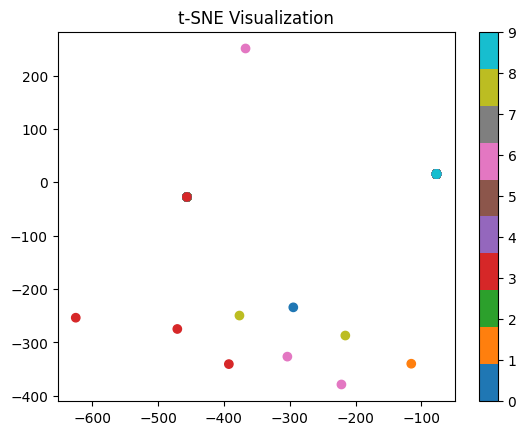

In [7]:
def train_model(model_name, opt_name, epochs, loss_name):
    model = get_model(model_name).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001) if opt_name == "Adam" else optim.SGD(model.parameters(), lr=0.01)
    criterion = FocalLoss() if loss_name == "Focal Loss" else nn.CrossEntropyLoss()

    print(f"Training {model_name}...")
    for epoch in range(epochs):
        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}] complete.")
    return model

def visualize_tsne(model):
    model.eval()
    features, labels_list = [], []
    with torch.no_grad():
        for i, (images, labels) in enumerate(testloader):
            images = images.to(device)
            output = model(images)
            features.append(output.cpu().numpy())
            labels_list.append(labels.numpy())
            if i > 10: break # Small subset for speed

    tsne = TSNE(n_components=2).fit_transform(np.concatenate(features))
    plt.scatter(tsne[:, 0], tsne[:, 1], c=np.concatenate(labels_list), cmap='tab10')
    plt.colorbar()
    plt.title("t-SNE Visualization")
    plt.show()

# Example Execution for your table[cite: 18]:
vgg_model = train_model("VGGNet", "Adam", 10, "BCE")
visualize_tsne(vgg_model)